# Analyze the performance of the classification model for 30 tree species based on LeafSnap data subset

### Settings

In [7]:
# Imports
import warnings
warnings.simplefilter('ignore')

import numpy as np
from numpy import load
import os.path
import matplotlib.pyplot as plt
import pandas as pd

import keras.backend as K
if(K.tensorflow_backend):
    import tensorflow as tf
    tf.logging.set_verbosity(tf.logging.ERROR)
from keras.utils import np_utils
from keras.models import load_model

from code import data as d
from code import model as m

### Load the data 

In [8]:
original_data_path = "/home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-30subset/"
images_fname = os.path.join(original_data_path, "images.npz")
labels_fname = os.path.join(original_data_path, "labels.npz")
info_fname_rand = os.path.join(original_data_path, "leafsnap-dataset-30subset-images-enhanced-randomized.txt")

# load data
image_data = np.load(images_fname)
labels_data = np.load(labels_fname)
info_data = pd.read_csv(info_fname_rand,sep=r'\s*,\s*',header=0, encoding='ascii', engine='python')

images = image_data['images']
labels_one_hot = labels_data['labels_one_hot']


print('Image size: ', np.shape(images))
print('Labels one hot size: ', np.shape(labels_one_hot))

nim = len(labels_one_hot)
print('Number of images: ', nim)

info_data.tail()

Image size:  (6136, 64, 64, 3)
Labels one hot size:  (6136, 30)
Number of images:  6136


,filename,label,source,label_numeric,path
6131,pi0057-05-1.jpg,Tilia americana,lab,15,dataset/images/lab/Auto_cropped/tilia_american...
6132,wb1194-05-2.jpg,Betula lenta,lab,3,dataset/images/lab/Auto_cropped/betula_lenta/w...
6133,pi0005-05-3.jpg,Ptelea trifoliata,lab,25,dataset/images/lab/Auto_cropped/ptelea_trifoli...
6134,ny1124-02-2.jpg,Broussonettia papyrifera,lab,23,dataset/images/lab/Auto_cropped/broussonettia_...
6135,1249580214_0004.jpg,Magnolia grandiflora,field,8,dataset/images/field/magnolia_grandiflora/1249...


### Get the test data

In [9]:
[_, _, images_test,_, _, labels_one_hot_test,end_train_ind, end_val_ind] = d.split_data(images,labels_one_hot)
print('Image size - test set: ', np.shape(images_test))
print('Labels size - test set: ', np.shape(labels_one_hot_test)) 

print('Indicies: ', end_train_ind,', ', end_val_ind)

Image size - test set:  (614, 64, 64, 3)
Labels size - test set:  (614, 30)
Indicies:  4295 ,  5522


In [10]:
# splitting some of of the info data
labels_numeric_test = info_data.loc[end_val_ind:nim, "label_numeric"]
labels_test = info_data.loc[end_val_ind:nim, "label"]
filenames_test = info_data.loc[end_val_ind:nim, "filename"]
sources_test = info_data.loc[end_val_ind:nim, "source"]
path_test = info_data.loc[end_val_ind:nim, "path"]

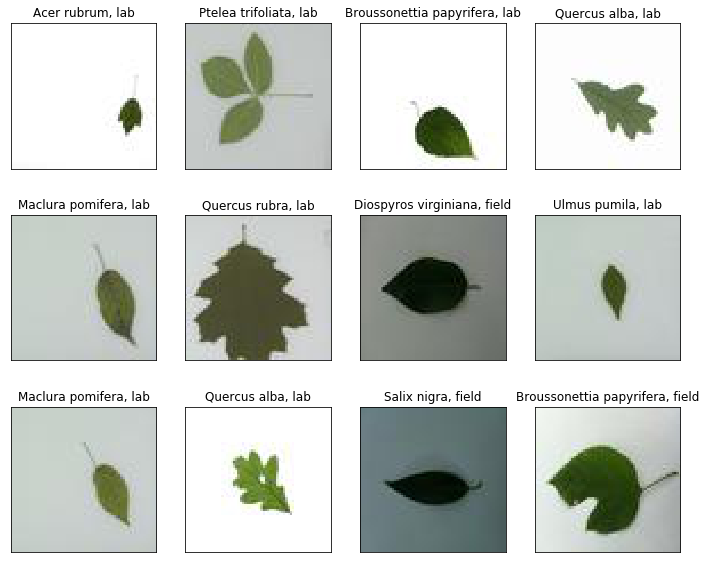

In [11]:
# plot random test images
d.plot_12images(images_test, labels_test, sources_test, figsize=(12,10))

### Load the model

In [13]:
best_model_file = model_fname = os.path.join(original_data_path, 'Models','leafnet.h5')

print('Loading the best model...')
model = load_model(best_model_file)
print('Best Model loaded!')


Loading the best model...
Best Model loaded!


### Create a dataset with predicted labels

In [15]:
pred = model.predict_classes(images_test)
predictions= pd.DataFrame({'prediction': pred, 'label_numeric': labels_numeric_test, 'label': labels_test, 'source': sources_test, 'filename':filenames_test, 'path':path_test})
#order columns
predictions = predictions[['prediction', 'label_numeric', 'label', 'source', 'filename', 'path']]
predictions.head()

,prediction,label_numeric,label,source,filename,path
5522,27,27,Abies concolor,lab,ny1178-10-1.jpg,dataset/images/lab/Auto_cropped/abies_concolor...
5523,17,22,Acer rubrum,lab,pi2773-04-4.jpg,dataset/images/lab/Auto_cropped/acer_rubrum/pi...
5524,28,17,Ulmus americana,lab,pi0020-02-2.jpg,dataset/images/lab/Auto_cropped/ulmus_american...
5525,4,5,Celtis occidentalis,field,1248106179_0005.jpg,dataset/images/field/celtis_occidentalis/12481...
5526,7,7,Magnolia acuminata,lab,wb1221-02-1.jpg,dataset/images/lab/Auto_cropped/magnolia_acumi...


### Plot confusion matrix

In [16]:
def plot_confusion_matrix(y_actu, y_pred, title='Confusion matrix', cmap=plt.cm.gray_r, figsize=(100,70), col_range_min=0, col_range_max=30):
    '''
    Creates a confusion matrix mapping actual labels vs. predicted labels, showing the height of values in each cell in color intensity.
    
    Input:
    - y_actu: actual labels
    - y_pred: predicted labels
    - title: title of the plot
    - cmap: color mapping
    - figsize: tuple of (w,h) determining the size of the plot
    - col_range_min /_max: min and max cell-value height the color intensity is based on, approx. amount of test data / number of classes
    
    Returns:
    - confusion matrix
    '''
    
    #create crosstab
    df_confusion = pd.crosstab(y_actu, y_pred.reshape(y_pred.shape[0],), rownames=['Actual'], colnames=['Predicted'], margins=True)
    
    df_conf_norm = df_confusion / df_confusion.sum(axis=1)
    
    #scale plot to requested figur size
    plt.figure(figsize=figsize)
    
    #plot crosstab
    plt.matshow(df_confusion, cmap=cmap, fignum=1) # imshow
    #plt.title(title)
    
    #apply min and max ranges
    plt.clim(col_range_min, col_range_max)
    #create colorbar for the legend
    plt.colorbar()
    #create axes ticks
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    
    #label axes
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

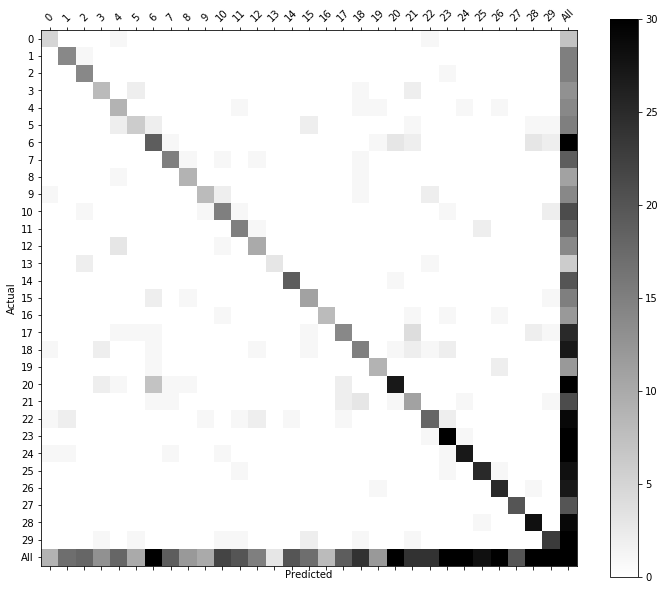

In [20]:
plot_confusion_matrix(labels_numeric_test, pred, figsize=(12,10), col_range_min=0, col_range_max=30)

In [ ]:
#pd.crosstab(labels_numeric_test, pred, rownames=labels_test)

In [55]:
species_and_labels = info_data[["label_numeric","label"]]
species = info_data.groupby("label")
species_numeric = np.unique(info_data["label_numeric"].values)
#print(species_and_labels)
#print(np.shape(species_and_labels))
print(species.head())
#print(species_numeric)

                filename                     label source  label_numeric  \
0        pi2775-03-2.jpg          Maclura pomifera    lab             20   
1        wb1566-03-1.jpg          Acer platanoides    lab              1   
2        pi0219-05-4.jpg                Ilex opaca    lab             21   
3     13001155905681.jpg               Acer rubrum  field             22   
4     13001252073566.jpg  Broussonettia papyrifera  field             23   
5        ny1124-02-1.jpg  Broussonettia papyrifera    lab             23   
6     13291736091481.jpg              Ulmus pumila  field             26   
7        wb1563-09-2.jpg           Quercus bicolor    lab             12   
8     13292231179100.jpg           Quercus montana  field             29   
9        ny1094-09-2.jpg          Prunus sargentii    lab             24   
10       pi0039-06-4.jpg           Quercus montana    lab             29   
11       ny1157-16-4.jpg            Abies concolor    lab             27   
12       pi0